<a href="https://colab.research.google.com/github/ngoda/Conversations/blob/master/b2CHAPTER5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CHAPTER 5 - BOOK2**


**Implementation of forward propagation method**

In [9]:
import sys
sys.path.append('..')  # Adds parent directory to the system path
from common.np import *  # Imports necessary NumPy functions
from common.layers import *  # Imports common layers
from common.functions import sigmoid  # Imports the sigmoid function



In [10]:
class RNN:
    def __init__(self, Wx, Wh, b):
        # Initialize the RNN cell with parameters Wx, Wh, and b
        self.params = [Wx, Wh, b]  # Store the parameters
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  # Initialize gradients with zeros
        self.cache = None  # Cache for storing intermediate data during backward pass

    def forward(self, x, h_prev):
        # Perform forward pass of the RNN cell
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b  # Compute the weighted sum
        h_next = np.tanh(t)  # Apply the tanh activation function

        self.cache = (x, h_prev, h_next)  # Cache the inputs and outputs for backward pass
        return h_next

    def backward(self, dh_next):
        # Perform backward pass of the RNN cell
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # Compute gradient of tanh activation
        db = np.sum(dt, axis=0)  # Gradient of the bias
        dWh = np.dot(h_prev.T, dt)  # Gradient of the hidden-to-hidden weights
        dh_prev = np.dot(dt, Wh.T)  # Gradient of the previous hidden state
        dWx = np.dot(x.T, dt)  # Gradient of the input-to-hidden weights
        dx = np.dot(dt, Wx.T)  # Gradient of the input

        # Update gradients
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


**Implementation of Time RNN Layer**

In [12]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        # Initialize the TimeRNN layer with parameters Wx, Wh, and b
        self.params = [Wx, Wh, b]  # Store the parameters
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  # Initialize gradients with zeros
        self.layers = None  # Initialize layers list

        self.h, self.dh = None, None  # Initialize hidden state and its gradient
        self.stateful = stateful  # Determine if the layer is stateful or not

    def set_state(self, h):
        # Set the hidden state
        self.h = h

    def reset_state(self):
        # Reset the hidden state
        self.h = None

    def forward(self, xs):
        # Perform forward pass of the TimeRNN layer
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape

        self.layers = []  # Initialize layers list
        hs = np.empty((N, T, H), dtype='f')  # Initialize hidden states array

        if not self.stateful or self.h is None:  # If not stateful or hidden state is not set
            self.h = np.zeros((N, H), dtype='f')  # Initialize hidden state

        for t in range(T):
            layer = RNN(*self.params)  # Create RNN layer
            self.h = layer.forward(xs[:, t, :], self.h)  # Perform forward pass for each time step
            hs[:, t, :] = self.h  # Store hidden state
            self.layers.append(layer)  # Append RNN layer to layers list

        return hs

    def backward(self, dhs):
        # Perform backward pass of the TimeRNN layer
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')  # Initialize gradient of input data
        dh = 0  # Initialize gradient of hidden state
        grads = [0, 0, 0]  # Initialize gradients of parameters

        for t in reversed(range(T)):
            layer = self.layers[t]  # Retrieve RNN layer
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # Perform backward pass for each time step
            dxs[:, t, :] = dx  # Store gradient of input data

            for i, grad in enumerate(layer.grads):
                grads[i] += grad  # Accumulate gradients

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad  # Update parameter gradients
        self.dh = dh  # Store gradient of hidden state

        return dxs


**Implementation of RNNLM**

In [13]:
import sys
sys.path.append('..')  # Adds parent directory to the system path

import numpy as np  # Imports NumPy library
from common.time_layers import *  # Imports time-related layers from a common module

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # Constructor method for SimpleRnnlm class
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn  # Random number generator function

        # Xavier initialization for weights
        embed_W = (rn(V, D) / 100).astype('f')  # Embedding layer weights
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')  # RNN input-to-hidden weights
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')  # RNN hidden-to-hidden weights
        rnn_b = np.zeros(H).astype('f')  # RNN bias
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')  # Output layer weights
        affine_b = np.zeros(V).astype('f')  # Output layer bias

        # Initialize layers
        self.layers = [
            TimeEmbedding(embed_W),  # Time-distributed embedding layer
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),  # Time-distributed RNN layer
            TimeAffine(affine_W, affine_b),  # Time-distributed affine layer
        ]
        self.loss_layer = TimeSoftmaxWithLoss()  # Time-distributed softmax with loss layer
        self.rnn_layer = self.layers[1]  # RNN layer

        # Parameters and gradients initialization
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        # Forward pass through the network
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)  # Compute loss
        return loss

    def backward(self, dout=1):
        # Backward pass through the network
        dout = self.loss_layer.backward(dout)  # Compute gradients of loss
        for layer in reversed(self.layers):
            dout = layer.backward(dout)  # Backpropagate gradients
        return dout

    def reset_state(self):
        # Reset the state of the RNN layer
        self.rnn_layer.reset_state()


 **RNNLM's Training Code**

Corpus size: 1000, Vocabulary size: 418
| Epoch 1 | Perplexity 395.29
| Epoch 2 | Perplexity 266.92
| Epoch 3 | Perplexity 224.50
| Epoch 4 | Perplexity 215.38
| Epoch 5 | Perplexity 205.50
| Epoch 6 | Perplexity 201.89
| Epoch 7 | Perplexity 197.68
| Epoch 8 | Perplexity 196.69
| Epoch 9 | Perplexity 192.34
| Epoch 10 | Perplexity 192.68
| Epoch 11 | Perplexity 188.06
| Epoch 12 | Perplexity 191.26
| Epoch 13 | Perplexity 190.16
| Epoch 14 | Perplexity 190.18
| Epoch 15 | Perplexity 188.87
| Epoch 16 | Perplexity 185.37
| Epoch 17 | Perplexity 183.89
| Epoch 18 | Perplexity 180.81
| Epoch 19 | Perplexity 181.43
| Epoch 20 | Perplexity 181.62
| Epoch 21 | Perplexity 180.82
| Epoch 22 | Perplexity 175.70
| Epoch 23 | Perplexity 173.34
| Epoch 24 | Perplexity 174.77
| Epoch 25 | Perplexity 170.39
| Epoch 26 | Perplexity 172.01
| Epoch 27 | Perplexity 165.94
| Epoch 28 | Perplexity 163.99
| Epoch 29 | Perplexity 160.52
| Epoch 30 | Perplexity 155.50
| Epoch 31 | Perplexity 154.93
| Epoch 

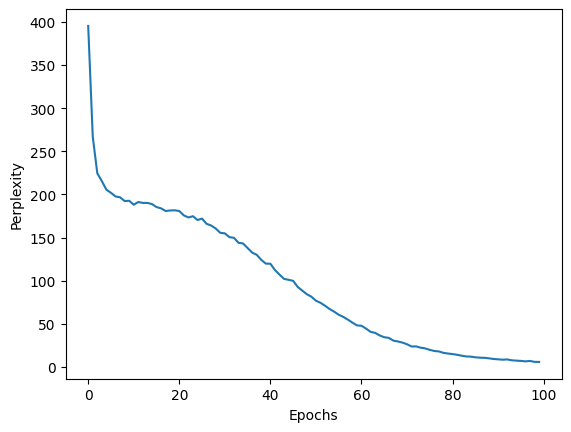

In [15]:

%matplotlib inline
import sys
sys.path.append('..')  # Adds parent directory to the system path

import matplotlib.pyplot as plt  # Imports matplotlib library for plotting
import numpy as np  # Imports NumPy library
from common.optimizer import SGD  # Imports SGD optimizer from a common module
from dataset import ptb  # Imports PTB dataset module
from simple_rnnlm import SimpleRnnlm  # Imports SimpleRnnlm class from a custom module

# Hyperparameters
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# Load and preprocess PTB dataset
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # Limit corpus size for faster training
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

# Split corpus into input and target sequences
xs = corpus[:-1]  # Input sequence
ts = corpus[1:]   # Target sequence
data_size = len(xs)
print('Corpus size: %d, Vocabulary size: %d' % (corpus_size, vocab_size))

# Calculate the number of iterations per epoch
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# Initialize the RNN language model and optimizer
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# Determine offsets for each batch to create mini-batches
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

# Training loop
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # Prepare mini-batch inputs and targets
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # Forward pass, backward pass, and parameter update
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # Compute perplexity and print progress
    ppl = np.exp(total_loss / loss_count)
    print('| Epoch %d | Perplexity %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# Plot the training perplexity over epochs
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()
